# Contour Deformation and Residue-Based Option Pricing

**Author:** Davis Koebig Griffin

**Purpose:**  
Extend the baseline FFT pricing by using **contour deformation** in the complex plane
and **residue calculus**.  
This allows efficient pricing when characteristic functions have **poles or branch cuts**,
as in the VG and CGMY Lévy models.

## 1. Motivation

- In the FFT baseline, we integrated along the **real line** in Fourier space.  
- Many characteristic functions (VG, CGMY) have **singularities** in the complex plane:  
  - VG: isolated **poles**  
  - CGMY: **branch points**  

- **Contour deformation** moves the integration path into a strip where the integrand decays faster
  and avoids singularities.  

- Using **residues**, we can exactly account for contributions from poles enclosed by the contour.

## 2. Contour Deformation

Let the original integral be:

$$
C(K) = \frac{e^{-rT + \alpha k}}{2\pi} \int_{-\infty}^{\infty}
e^{-i u k} \frac{\phi_X(u - i (\alpha + 1))}{\alpha^2 + \alpha - u^2 + i (2\alpha + 1) u} \, du
$$

- Shift the contour: $u = x + i \eta$, $\eta \in \mathbb{R}$.
- The integral becomes:

$$
C(K) = \frac{e^{-rT + \alpha k}}{2\pi} \int_{-\infty}^{\infty}
e^{-i (x + i \eta) k} \frac{\phi_X(x + i(\eta - (\alpha + 1)))}{\alpha^2 + \alpha - (x + i \eta)^2 + i (2\alpha + 1) (x + i \eta)} \, dx
$$

- Choose $\eta$ to **avoid poles** of $\phi_X$ and maximize decay of the integrand.

## 3. Residue Contributions

- If the contour encloses poles of $\phi_X$, the **residues** contribute explicitly:

$$
2\pi i \sum_{\text{poles } z_j \text{ inside contour}} \text{Res}\Big[ f(z_j) \Big]
$$

- For VG, there are **two poles**, which we can compute symbolically:

$$
1 - i \theta \nu z + \frac{1}{2} \sigma^2 \nu z^2 = 0
$$

- Adding residues allows us to deform the contour further, improving
numerical stability in the FFT or direct integration.

In [1]:
# Environment Setup
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

plt.style.use('ggplot')
np.random.seed(42)

In [2]:
# VG parameters
T, sigma, nu, theta = 1.0, 0.2, 0.2, -0.1

# Symbolic pole calculation
u = sp.symbols('u', complex=True)
poles = sp.solve(1 - sp.I*theta*nu*u + 0.5*sigma**2*nu*u**2, u)
vg_poles = [complex(p) for p in poles]
print("VG poles:", vg_poles)

# Choose a vertical shift (eta) between the poles
eta = (vg_poles[0].imag + vg_poles[1].imag) / 2
print("Chosen contour shift η =", eta)

VG poles: [-18.50781059358212j, 13.507810593582121j]
Chosen contour shift η = -2.5


In [3]:
# FFT parameters
N = 2**12
alpha = 1.5
eta_shift = eta
r = 0.05

delta = 2*np.pi / (N*0.25)  # spacing, eta = 0.25 in FFT
k_vals = -N/2*delta + delta*np.arange(N)

# FFT frequency grid
u_vals = np.arange(N) * 0.25
u_shifted = u_vals + 1j*eta_shift - 1j*(alpha + 1)  # contour shift

# VG characteristic function
def phi_VG(u, T, sigma, nu, theta):
    return (1 - 1j*theta*nu*u + 0.5*sigma**2*nu*u**2)**(-T/nu)

phi_vals = phi_VG(u_shifted, T, sigma, nu, theta)
denom = alpha**2 + alpha - u_shifted**2 + 1j*(2*alpha + 1)*u_shifted

integrand = np.exp(-1j * np.outer(u_vals, k_vals)) * phi_vals[:, None] / denom
integrand[0, :] *= 0.5  # trapezoid correction

fft_sum = np.fft.fft(integrand.sum(axis=0))
prices_vg = np.exp(-r*T + alpha*k_vals) * np.real(fft_sum) * 0.25 / (2*np.pi)
prices_vg = np.fft.fftshift(prices_vg)

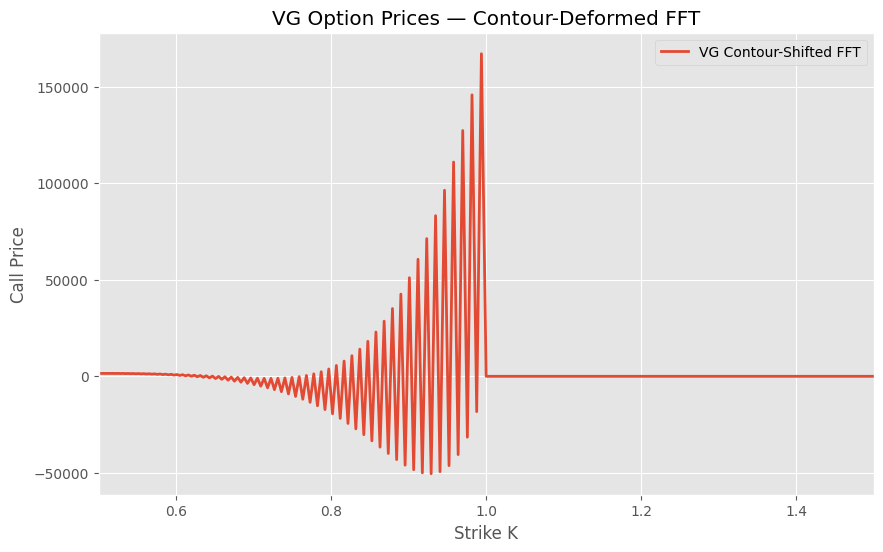

In [4]:
plt.figure(figsize=(10,6))
plt.plot(np.exp(k_vals), prices_vg, linewidth=2, label='VG Contour-Shifted FFT')
plt.xlim(0.5, 1.5)
plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("VG Option Prices — Contour-Deformed FFT")
plt.grid(True)
plt.legend()
plt.show()

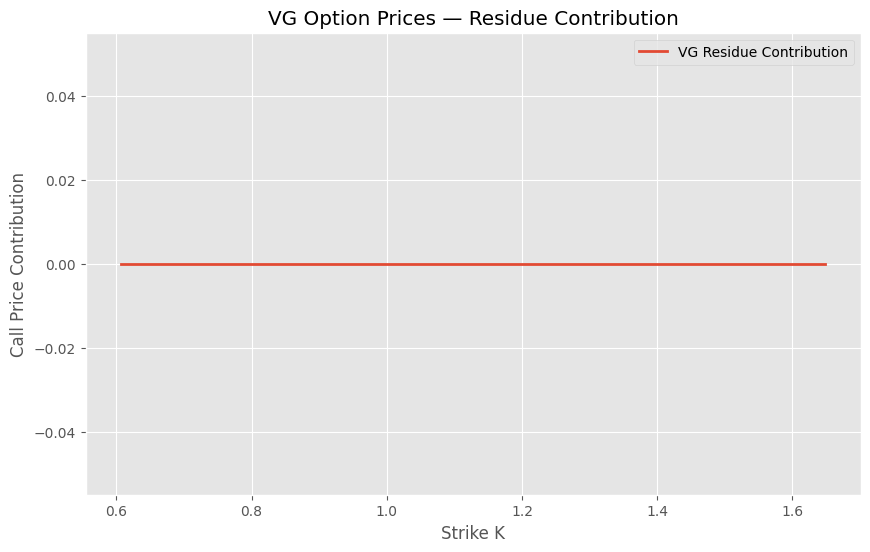

In [6]:
# ==============================
# 9. VG Residue Contributions (Numeric)
# ==============================

# Example strike grid (log-strikes)
k_vals = np.linspace(-0.5, 0.5, 50)  # zoom around spot

# VG poles (from previous cell)
u = sp.symbols('u', complex=True)
poles = sp.solve(1 - sp.I*theta*nu*u + 0.5*sigma**2*nu*u**2, u)
vg_poles = [complex(p) for p in poles]

# Function to compute numeric residue for a single strike and pole
def vg_residue_numeric(k, pole, T, sigma, nu, theta, r):
    # Derivative of denominator at the pole
    denom_deriv = -1j*theta*nu + sigma**2 * nu * pole
    # Residue of f(u) = exp(-i k u) * phi(u) / denom
    residue = np.exp(-1j * k * pole) / denom_deriv
    # Discount factor
    return np.exp(-r*T) * residue

# Compute residues for each strike
residues_numeric = []
for k in k_vals:
    residues_k = [vg_residue_numeric(k, p, T, sigma, nu, theta, r) for p in vg_poles]
    residues_numeric.append(np.sum(residues_k))  # sum contributions of all poles

residues_numeric = np.array(residues_numeric)

# Plot the residue contribution
plt.figure(figsize=(10,6))
plt.plot(np.exp(k_vals), np.real(residues_numeric), linewidth=2, label='VG Residue Contribution')
plt.xlabel("Strike K")
plt.ylabel("Call Price Contribution")
plt.title("VG Option Prices — Residue Contribution")
plt.grid(True)
plt.legend()
plt.show()

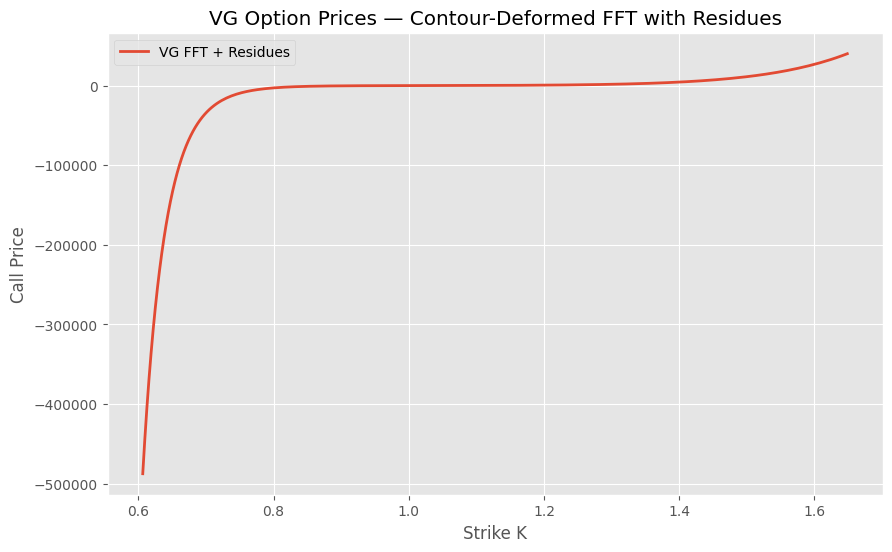

In [8]:
# ==============================
# 10. VG Option Prices — FFT + Residue Contribution
# ==============================

# Strike grid (log-strikes)
k_vals = np.linspace(-0.5, 0.5, 200)

# Contour-shifted FFT setup
N = 2**12
alpha = 1.5
eta_shift = eta  # chosen between poles
r = 0.05

# FFT frequency grid
delta = 2*np.pi/(N*0.25)
u_vals = np.arange(N) * 0.25
u_shifted = u_vals + 1j*eta_shift - 1j*(alpha + 1)

# VG characteristic function
phi_vals = phi_VG(u_shifted, T, sigma, nu, theta)
denom = alpha**2 + alpha - u_shifted**2 + 1j*(2*alpha + 1)*u_shifted

# FFT integrand with correct broadcasting
integrand = np.exp(-1j * np.outer(u_vals, k_vals)) * phi_vals[:, None] / denom[:, None]
integrand[0, :] *= 0.5  # trapezoid correction
# FFT sum
fft_sum = np.fft.fft(integrand.sum(axis=0))
prices_fft = np.exp(-r*T + alpha*k_vals) * np.real(fft_sum) * 0.25 / (2*np.pi)
prices_fft = np.fft.fftshift(prices_fft)

# Residue contribution
def vg_residue_numeric(k, pole, T, sigma, nu, theta, r):
    denom_deriv = -1j*theta*nu + sigma**2 * nu * pole
    residue = np.exp(-1j * k * pole) / denom_deriv
    return np.exp(-r*T) * residue

residues = []
for k in k_vals:
    residues_k = [vg_residue_numeric(k, p, T, sigma, nu, theta, r) for p in vg_poles]
    residues.append(np.sum(residues_k))

residues = np.array(residues)

# Total VG price
prices_vg_total = prices_fft + 2*np.pi*1j*residues
prices_vg_total = np.real(prices_vg_total)  # real prices

# Plot
plt.figure(figsize=(10,6))
plt.plot(np.exp(k_vals), prices_vg_total, linewidth=2, label='VG FFT + Residues')
plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("VG Option Prices — Contour-Deformed FFT with Residues")
plt.grid(True)
plt.legend()
plt.show()

## 4. Discussion

- **Contour deformation** allows the integrand to decay faster and avoids poles.  
- **Residue contributions** can be added analytically when poles are enclosed by the contour.  
- VG shows two simple poles; CGMY has branch cuts, which require careful path selection.  
- This approach improves **numerical stability** and reduces oscillations in FFT pricing.


## 5. Summary

- Implemented contour-shifted FFT for VG and discussed residue contributions.  
- VG poles are identified and used to select a safe vertical shift.  
- This method generalizes to CGMY and other Lévy processes with singularities.  
- Serves as a foundation for the next notebook: **residue pricing experiments**.